In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
%cd /content/gdrive/MyDrive/SLIIT/Data_Science/FDM/mini-project

/content/gdrive/MyDrive/SLIIT/Data_Science/FDM/mini-project


In [ ]:
#importing necessary libraries
import pandas as pd
import os
import numpy as np 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
data=pd.read_csv("house_rent_new2.csv")

This dataset has already been preprocessed during the development of the regression model. Outliers are removed, and the imbalance state of the dataset is removed using 'Over Sampling'.

In [ ]:
data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,rent_scale,size_scale
0,2022-07-03,1,24000,710,1 out of 1,Super Area,Salt Lake City Sector 1,Kolkata,Furnished,Bachelors,1,1,3
1,2022-06-16,2,36000,1200,1 out of 4,Carpet Area,whitefield,Bangalore,Furnished,Bachelors/Family,2,2,5
2,2022-05-23,1,5000,500,1 out of 4,Super Area,"Bydara Halli, Benson Town",Bangalore,Semi-Furnished,Family,1,0,2
3,2022-05-16,2,15000,1180,4 out of 5,Super Area,"Miyapur, NH 9",Hyderabad,Semi-Furnished,Bachelors/Family,2,1,5
4,2022-05-27,2,18000,600,Ground out of 3,Super Area,Bagha Jatin Pally,Kolkata,Semi-Furnished,Bachelors/Family,2,1,2


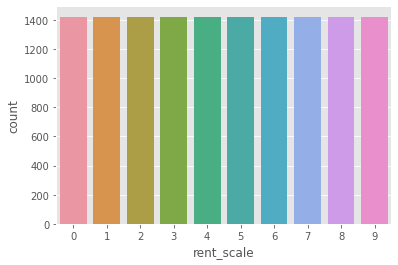

In [ ]:
sns.countplot(x='rent_scale', data=data)

you can see the imbalance state of data is removed.

In [ ]:
#renaming columns to make things easier
data.rename(columns = {'Area Type':'Area_Type'}, inplace = True)
data.rename(columns = {'Area Locality':'Area_Locality'}, inplace = True)
data.rename(columns = {'Furnishing Status':'Furnishing_Status'}, inplace = True)
data.rename(columns = {'Tenant Preferred':'Tenant_Preferred'}, inplace = True)

In [ ]:
for x in data.columns:
    #prinfting unique values
    print(x ,':', len(data[x].unique()))

BHK : 3
Area_Type : 3
City : 6
Furnishing_Status : 3
Tenant_Preferred : 3
Bathroom : 3
rent_scale : 10
size_scale : 10



The 'Floor', and 'Area_Locality' have too many classes, which will not help to use one-hot encoding. If applied it will result in 'multicollinearity'. So both columns are removed. Also since 'Rent_scale' & 'size_scale' have been introduced, 'size' & 'rent' needs to be removed from the dataset.

In [ ]:
data.drop('Floor', inplace=True, axis=1)

In [ ]:
data.drop('Area_Locality',inplace=True, axis=1)

In [ ]:
data.drop('Rent',inplace=True, axis=1)

In [ ]:
data.drop('Size',inplace=True, axis=1)

In [ ]:
data.head() #new dataset

,BHK,Area_Type,City,Furnishing_Status,Tenant_Preferred,Bathroom,rent_scale,size_scale
0,1,Super Area,Kolkata,Furnished,Bachelors,1,1,3
1,2,Carpet Area,Bangalore,Furnished,Bachelors/Family,2,2,5
2,1,Super Area,Bangalore,Semi-Furnished,Family,1,0,2
3,2,Super Area,Hyderabad,Semi-Furnished,Bachelors/Family,2,1,5
4,2,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,2,1,2


Area Type, City, Furnishing Status, and tenent Preferred needs to be converted into numeric. One-Hot encoding is used to do this.

In [ ]:
#city
City_types = pd.get_dummies(data.City)
City_types.head()

data.drop('City',inplace=True, axis=1)

In [ ]:
#Furnishing status
Furnishing_types = pd.get_dummies(data.Furnishing_Status)
Furnishing_types.head()

data.drop('Furnishing_Status',inplace=True, axis=1)

In [ ]:
#Area Type
Area_types = pd.get_dummies(data.Area_Type)
Area_types.head()

data.drop('Area_Type',inplace=True, axis=1)

In [ ]:
#Tenant preferred
Tenant_types = pd.get_dummies(data.Tenant_Preferred)
Tenant_types.head()

data.drop('Tenant_Preferred',inplace=True, axis=1)

Now all the datafarmes are merged into one single dataframe.


In [ ]:
new_dataFrame=data.join(Area_types).join(Tenant_types).join(Furnishing_types).join(City_types)
new_dataFrame.head()

,BHK,Bathroom,rent_scale,size_scale,Built Area,Carpet Area,Super Area,Bachelors,Bachelors/Family,Family,Furnished,Semi-Furnished,Unfurnished,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,1,1,1,3,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,2,2,2,5,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
2,1,1,0,2,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,2,2,1,5,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
4,2,2,1,2,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0


Correlation is calculated for all the columns to identify the strength of the relationship between attributes. Especially between 'Rent_scale' and all the other attributes. Attributes with a weak relationship with 'rent_scale' will be removed since it won't help for the classification model.

In [ ]:
px.imshow(new_dataFrame.corr(),title="Correlation Plot of the Housing dataset")

One-Hot encoding for handling categorical data is the best for non-tree based algorithms. For tree based algorithms this is not going to work well. So we shall perform nor-tree based classification algorithms.

In [ ]:
columns = new_dataFrame.columns
columns

Index(['BHK', 'Bathroom', 'rent_scale', 'size_scale', 'Built Area',
       'Carpet Area', 'Super Area', 'Bachelors', 'Bachelors/Family', 'Family',
       'Furnished', 'Semi-Furnished', 'Unfurnished', 'Bangalore', 'Chennai',
       'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai'],
      dtype='object')

In [ ]:
columns=columns.drop("rent_scale")

In [ ]:
X=new_dataFrame[columns]
Y=new_dataFrame['rent_scale'].values
print(X)
print(Y)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#Splitting the datset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=4)

In [ ]:
X_train.head()

,BHK,Bathroom,size_scale,Built Area,Carpet Area,Super Area,Bachelors,Bachelors/Family,Family,Furnished,Semi-Furnished,Unfurnished,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
11779,3,3,6,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
8152,3,2,5,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
10119,2,2,3,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
5307,2,2,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
12866,3,3,5,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
X_train.ndim

2

In [ ]:
X_test.head()

,BHK,Bathroom,size_scale,Built Area,Carpet Area,Super Area,Bachelors,Bachelors/Family,Family,Furnished,Semi-Furnished,Unfurnished,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
5186,3,3,9,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0
6734,2,2,3,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1
13609,3,3,6,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1
2235,2,2,3,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
8367,3,3,6,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_test.ndim

2

Now we will create diffeent classification models & check their accuracy to determine the best model for the dataset.


In [ ]:
#Support vector classification

from sklearn.svm import SVC #SVC - support vector classification

SVC_model = SVC(kernel='rbf', C=1, gamma=0.001, random_state=1)
SVC_model.fit(X_train,Y_train)

from sklearn.metrics import accuracy_score

#since the model is crated, by sending test data we can get the output into y_predict 
y_predict = SVC_model.predict(X_test) 

#then we can compare the y_predict output the with the actual output in Y_test
print("Accuracy of the model : ", accuracy_score(Y_test,y_predict))

Accuracy of the model :  0.4244553759662684


In [ ]:
#cross validation
acc=cross_val_score(SVC_model,X,Y,cv=5,scoring="accuracy")
np.mean(acc)

0.4098383696416022

In [ ]:
#Naive Bayse classification

#import Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

#create gaussian classifier 
naiveBayes_model = GaussianNB()

#train the model
naiveBayes_model.fit(X_train,Y_train)

#predict the output using the created model
y_predict1=naiveBayes_model.predict(X_test)

#then we can compare the y_predict1 output the with the actual output in Y_test
print("Accuracy of the model : ", accuracy_score(Y_test,y_predict1))

Accuracy of the model :  0.3605059732958538


In [ ]:
#cross validation
acc=cross_val_score(naiveBayes_model,X,Y,cv=5,scoring="accuracy")
np.mean(acc)

0.3505270555165144

In [ ]:
#K-nearest neighbour algorithm for classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#create KNN classifier
KNN_classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  

#train the model
KNN_classifier.fit(X_train, Y_train)  

#predict the output using the model
y_predict2=KNN_classifier.predict(X_test)

#then we can compare the y_predict1 output the with the actual output in Y_test
print("Accuracy of the model : ",accuracy_score(Y_test,y_predict2))


Accuracy of the model :  0.567111735769501


In [ ]:
#cross validation
acc=cross_val_score(KNN_classifier,X,Y,cv=5,scoring="accuracy")
np.mean(acc)

0.5290934645115952

Since the accuracy of the KNN Algorithm is high, we shall select that to do future predictions.


In [ ]:
import pickle
pickle.dump(KNN_classifier,open('classification.pkl','wb'))